# **COMP 6721 Applied Artificial Intelligence**
# **(Fall 2020)**
> Project Assignment Part I

# **AI Face Mask Detector**

## **Setup**

In [1]:
# Import required libraries
import torch 
import os
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose, Resize, ToPILImage, ToTensor
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
from sklearn.metrics import classification_report
import matplotlib.image as mpimg
import itertools
from sklearn.metrics import confusion_matrix

**D**ownloading data from Kaggle.com

In [2]:
# Getting data from kaggle.com
%%capture
# Keys for env - API
os.environ['KAGGLE_USERNAME'] = "karandeepbhardwaj" # username from the json file
os.environ['KAGGLE_KEY'] = "a188728f8e2873a3cd0394bd2b543ffb" # key from the json file

# Bash commands to download data and unzip in source directory
!kaggle datasets download -d andrewmvd/animal-faces
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset
!unzip face-mask-12k-images-dataset.zip -d data_set
!unzip animal-faces.zip -d my_not_human_data
!rm -r sample_data
!rm animal-faces.zip
!rm face-mask-12k-images-dataset.zip

!mkdir "./myData"
!mkdir "./myData/Test"
!mkdir "./myData/Train"
!mkdir "./myData/Test/Mask"
!mkdir "./myData/Test/NoMask"
!mkdir "./myData/Test/NotHuman"

!mv "./data_set/Face Mask Dataset/Test/WithMask" "./myData/Test/Mask"
!mv "./data_set/Face Mask Dataset/Test/WithoutMask" "./myData/Test/NoMask"
!mv "./my_not_human_data/afhq/val/cat" "./myData/Test/NotHuman"

!mkdir "./myData/Train/Mask"
!mkdir "./myData/Train/NoMask"
!mkdir "./myData/Train/NotHuman"

!mv "./data_set/Face Mask Dataset/Train/WithMask" "./myData/Train/Mask"
!mv "./data_set/Face Mask Dataset/Train/WithoutMask" "./myData/Train/NoMask"
!mv "./my_not_human_data/afhq/train/cat" "./myData/Train/NotHuman"

!rm -r data_set
!rm -r my_not_human_data/

Paths to data folders created in source directory.

In [3]:
#Data Loading
classes = ['Masked', 'NotMasked', 'NotHuman']

maskPath = './myData/Train/Mask/'
nonMaskPath = './myData/Train/NoMask/'
nonHumanPath ='./myData/Train/NotHuman/'

testMask = './myData/Test/Mask/'
testNonMask = './myData/Test/NoMask/'
testNotHuman = './myData/Test/NotHuman/'

directories = {0:maskPath, 1:nonMaskPath, 2:nonHumanPath}
testDirectories = {0:testMask, 1:testNonMask , 2:testNotHuman}

**Data Extraction:** 
*   Extracting data from above defined paths.
*   Resizing Images.
*   Reading images from disk.
*   Writing to data as np array form to trainingData.


In [4]:
class PrepProcessingModel():
    IMAGESIZE = 100
    trainingData = []
    def makeDataSet(self, directoryType):
        for label, dataDirectory in directoryType.items():
            print('\n\n Currently reading Label: ',label,'\n')
            for folder in tqdm(os.listdir(dataDirectory)):
                folderPath = os.path.join(dataDirectory, folder);
                for imgpath in os.listdir(folderPath):
                    imagePath = os.path.join(folderPath, imgpath);
                    img = cv2.imread(imagePath);
                    img = cv2.resize(img, (self.IMAGESIZE,self.IMAGESIZE));
                    self.trainingData.append([np.array(img), label]);
        np.random.shuffle(self.trainingData)

Running PreProcessing to write image marked data to trainingData.

In [5]:
PrepProcessingModel = PrepProcessingModel()
PrepProcessingModel.makeDataSet(directories)
print("Labeling from Train Data:")
trainingData = PrepProcessingModel.trainingData

  0%|          | 0/1 [00:00<?, ?it/s]



 Currently reading Label:  0 



  0%|          | 0/1 [00:00<?, ?it/s]



 Currently reading Label:  1 



  0%|          | 0/1 [00:00<?, ?it/s]



 Currently reading Label:  2 



100%|██████████| 1/1 [00:16<00:00, 16.97s/it]


# Creating test data set

In [6]:
PrepProcessingModel.makeDataSet(testDirectories)
print("Labeling from Test Data:")
testData = PrepProcessingModel.trainingData

  0%|          | 0/1 [00:00<?, ?it/s]



 Currently reading Label:  0 



  0%|          | 0/1 [00:00<?, ?it/s]



 Currently reading Label:  1 



  0%|          | 0/1 [00:00<?, ?it/s]



 Currently reading Label:  2 



100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


In [7]:
_, test_data = torch.utils.data.random_split(testData, [(len(testData) - 3000), 3000])

* **Creating Pytorch Dataset**

In [12]:
# Creating pytorch Dataset by converting training data set from preprocessing to tensor data type.
class BuildDataSet(Dataset):
        def __init__(self, train_data):
            self.train_data = train_data
            self.transformations = Compose([
                ToTensor(),
            ])
        
        def __getitem__(self, key):
            if isinstance(key, slice):
                raise NotImplementedError('slicing is not supported')                    
            return [
                self.transformations(self.train_data[key][0]), torch.tensor(self.train_data[key][1])
            ]
        
        def __len__(self):
            return len(self.train_data)


> * Creating Training Data Loader
> * Creating validation Data Loader

In [13]:
myDataset = BuildDataSet(trainingData)
training_data, validation_data = torch.utils.data.random_split(myDataset, [(len(myDataset) - 3000), 3000])
batch_size = 32
train_dl = DataLoader(training_data, batch_size * 2, shuffle=True)
val_dl = DataLoader(validation_data, batch_size * 2)

In [14]:
myTestDataSet = BuildDataSet(trainingData)

# **Accuracy**

In [16]:
# Calculating accuracy from dataset
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    true_positives_negatives = torch.sum(preds == labels).item()
    total_predictions = len(preds)
    result = true_positives_negatives/total_predictions
    accuracy = torch.tensor(result)
    return accuracy

# **CNN** Architecture

In [17]:
class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        images, labels = batch 
        #Calculating Loss and Generating Predictions
        return F.cross_entropy(self(images), labels.long())
    
    def validation_step(self, batch):
        images, labels = batch
        #Calculating Loss and Generating Predictions
        return {'val_loss': F.cross_entropy(self(images), labels.long()).detach(),
                 'val_acc': accuracy(self(images), labels)}
        
    def validation_epoch_end(self, outputs):

        batchLosses = []
        batchAccuracies = []

        for x in outputs:
            batchLosses.append(x['val_loss'])
            batchAccuracies.append(x['val_acc'])

        epochLosses = torch.stack(batchLosses).mean()   # Combine losses
        epochAccuracies = torch.stack(batchAccuracies).mean()      # Combine accuracies

        return {'val_loss': epochLosses.item(), 'val_acc': epochAccuracies.item()}
    
    def epoch_end(self, epoch, result):
        print("\n\nEpoch: [{}]\n\nTraining Data Loss: {:.4f}\nValidation Data Loss: {:.4f}\nValidation data Accuracy: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

# **Convolution Neural Network**


*   Feature Learning
*   Classification



In [18]:
class CNNModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            #First convolution layer
            nn.Conv2d(3, 100, kernel_size=3, padding=1),
            nn.ReLU(),

            #Second convolution layer
            nn.Conv2d(100, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            #First pooling layer
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            
            #Third convolution layer
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            #Fourth convolution layer
            # nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            # nn.ReLU(),

            #Second pooling layer
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            
            #Flattening and rectification
            nn.Flatten(), 
            nn.Linear(160000, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 3))
        
    def forward(self, xb):
      return self.network(xb)

**Checking the availability of GPU**
> If not present then use CPU

In [19]:
device =  torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

> Move the tensor to chosen device for processing. (CPU or GPU)

In [20]:
def toDevice(data, device):
    if isinstance(data, (list, tuple)):
        myList = []
        for x in data:
            myList.append(toDevice(x, device))
        return myList
    return data.to(device, non_blocking=True)

# Overriding Dataloader methods
* Move data to device
* Yield a batch from device afterwards
* Get number of batches

In [21]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield toDevice(b, self.device)

    def __len__(self):
        return len(self.dl)

* Loading data to device

In [22]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

# **Training**

In [23]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = []
    for batch in val_loader:
        outputs.append(model.validation_step(batch))
    return model.validation_epoch_end(outputs)

> Train and Validate data from datasets

In [24]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

# Model (on GPU)

In [25]:
model = CNNModel()
toDevice(model, device);
model.eval();

history = [evaluate(model, val_dl)]
history

history = fit(15, 1e-3, model, train_dl, val_dl)

epoch:  0
Epoch: [0]
Training Data Loss: 0.9496
Validation Data Loss: 0.5733
Validation data Accuracy: 0.7657
epoch:  1
Epoch: [1]
Training Data Loss: 0.3975
Validation Data Loss: 0.2608
Validation data Accuracy: 0.9093
epoch:  2
Epoch: [2]
Training Data Loss: 0.2258
Validation Data Loss: 0.1906
Validation data Accuracy: 0.9330
epoch:  3
Epoch: [3]
Training Data Loss: 0.1781
Validation Data Loss: 0.1591
Validation data Accuracy: 0.9464
epoch:  4
Epoch: [4]
Training Data Loss: 0.1518
Validation Data Loss: 0.1475
Validation data Accuracy: 0.9481
epoch:  5
Epoch: [5]
Training Data Loss: 0.1346
Validation Data Loss: 0.1323
Validation data Accuracy: 0.9503
epoch:  6
Epoch: [6]
Training Data Loss: 0.1124
Validation Data Loss: 0.1054
Validation data Accuracy: 0.9611
epoch:  7
Epoch: [7]
Training Data Loss: 0.0936
Validation Data Loss: 0.1149
Validation data Accuracy: 0.9561
epoch:  8
Epoch: [8]
Training Data Loss: 0.0869
Validation Data Loss: 0.1082
Validation data Accuracy: 0.9583
epoch:  9


# **Plot the losses and accuracies**

In [26]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');
    
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

#saving to disk
torch.save(model.state_dict(), './MaskDetection.pth')

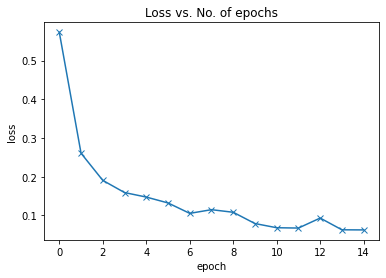

In [27]:
plot_losses(history)

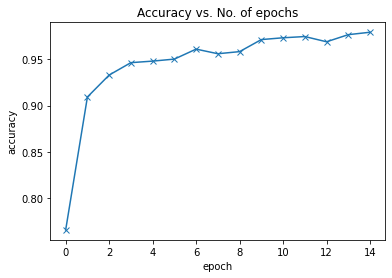

In [28]:
plot_accuracies(history)

> # **Testing images after modeling.**

In [29]:
# Testing
def singleImage(path, label= None, show= False):
    img = cv2.imread(path)
    assert img is not None,"Image wasn't read properly"
    img = cv2.resize(img, (100, 100))
    img = torch.from_numpy(img)
    img = img.permute((2, 0,1)) # model expects image to be of shape [3, 100, 100]
    img = img.unsqueeze(dim=0).float() # convert single image to batch [1, 3, 100, 100]
    img = img.to('cuda') # Using the same device as the model
    pred = model(img)
    _, preds = torch.max(pred, dim=1)
    print(classes[preds.item()])
    
    if show:
        plt.imshow(mpimg.imread(path))
        print("the image is :" + classes[preds.item()])

In [36]:
def valImage(key, typeOfData):
    img = typeOfData[key][0]
    pred = model(img.unsqueeze(dim=0).to(device))
    _, preds = torch.max(pred, dim=1)
    return (typeOfData[key][1],preds.item())

# **Display Result**

In [38]:
y_pred = []
x_act = []
for x in range(1000):
  actual, predicted = valImage(x, myTestDataSet)
  y_pred.append(predicted)
  x_act.append(actual)
y_pred = np.asarray(y_pred)
x_act = np.asarray(x_act)

In [39]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[317   3   5]
 [  6 330   0]
 [  0   0 339]]


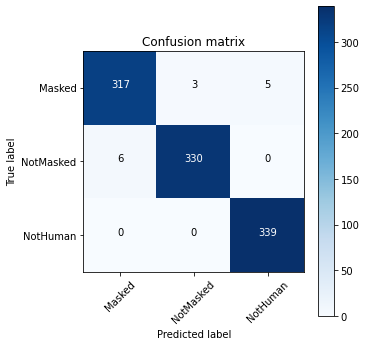

In [40]:
cm = confusion_matrix(y_pred, x_act)
plt.figure(figsize=(5,5))
plot_confusion_matrix(cm, classes);

In [41]:
all_scores = classification_report(y_pred, x_act)
print(all_scores)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       325
           1       0.99      0.98      0.99       336
           2       0.99      1.00      0.99       339

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000

